# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of train data will be __train_size__ (a value of your choice between 0.67 and 0.8)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


### Prepare the environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size'   : 12})
random_state = 17
train_size = 0.67
n_splits = 3
np.random.seed(random_state)
data = "default-of-credit-card-clients.xlsx"
target = 'DPNM'

Read the data into a dataframe and show the size

In [3]:
df = pd.read_excel(data, header=1)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Show the head of the dataframe and try to understand if everything is fine.

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.describe(include='all')

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DPNM
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Additional insights are provided by the number of distinct values in each column, or the average number of rows per distinct values of a column
Meaning of this ratio:
- Usually, it is exactly `1` when a column is an __identifier__. Usually identifiers are not useful for machine learning and must be dropped
- Usually it is a non integer small number (e.g. a few units) for continuous attributes.
- Usually it is a larger number (of the order of magnitude of the nunber of rows) for discrete attributes


In [5]:
anorpdvoac = len(df.index)/df.nunique()
anorpdvoac.sort_values()

ID               1.000000
BILL_AMT1        1.320248
BILL_AMT2        1.342522
BILL_AMT3        1.362027
BILL_AMT4        1.392241
BILL_AMT5        1.427891
BILL_AMT6        1.456028
PAY_AMT1         3.776910
PAY_AMT2         3.797949
PAY_AMT3         3.990423
PAY_AMT6         4.323390
PAY_AMT4         4.324636
PAY_AMT5         4.349717
LIMIT_BAL      370.370370
AGE            535.714286
PAY_4         2727.272727
PAY_3         2727.272727
PAY_2         2727.272727
PAY_0         2727.272727
PAY_6         3000.000000
PAY_5         3000.000000
EDUCATION     4285.714286
MARRIAGE      7500.000000
SEX          15000.000000
DPNM         15000.000000
dtype: float64

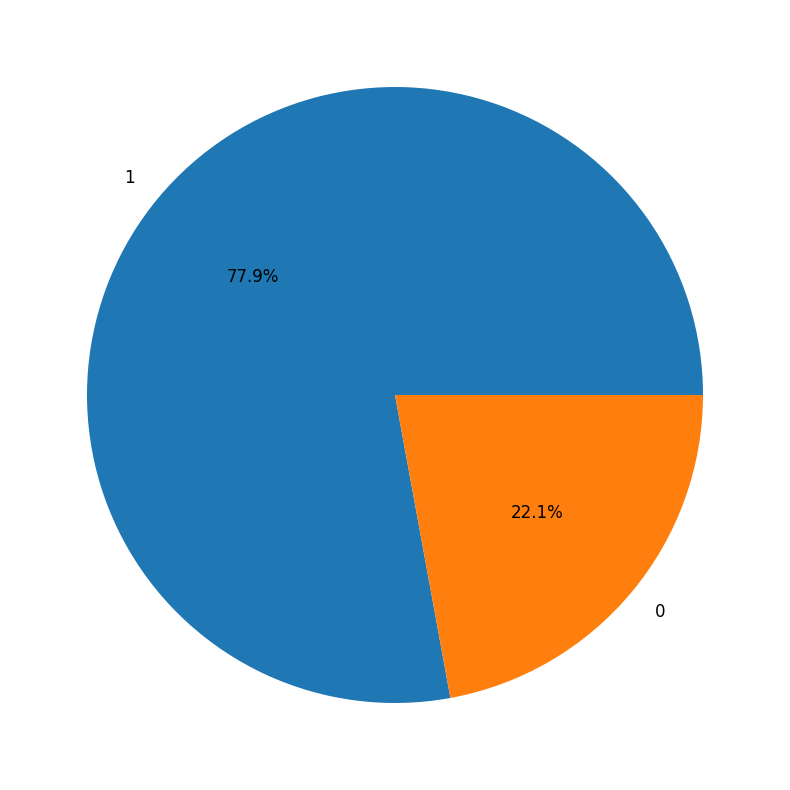

In [6]:
fig, ax = plt.subplots()
ax.pie(df['DPNM'].value_counts(), labels = df['DPNM'].unique(),autopct='%1.1f%%');

#### Split the data into the __predicting values__ `X` and the __target__ `y`


In [7]:
X=df.drop(columns='DPNM')
X
y=df['DPNM']

### Prepare the baseline: holdout method

In [8]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size, random_state = random_state)
Xtrain, Xtest, ytrain, ytest 



(          ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
 9206    9207     290000    2          3         1   29      0      0      0   
 20573  20574     180000    1          1         2   29      0      0      0   
 26316  26317     100000    2          6         1   29      0      0      0   
 17688  17689     440000    2          1         1   40      0      0      0   
 11889  11890      30000    2          2         2   22     -2     -2     -2   
 ...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
 9529    9530     370000    2          2         2   39      0      0      0   
 406      407     120000    2          2         1   25      0      0      0   
 13702  13703      60000    1          2         2   37      1     -2     -2   
 2191    2192     200000    2          1         2   29      1     -2     -1   
 10863  10864     150000    2          2         2   24     -2     -2     -2   
 
        PAY_4  ...  BILL_AMT3  BILL_AM

- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(random_state = random_state)`


In [9]:
dtc=DecisionTreeClassifier(random_state=0)

- Fit the estimator on the train data and target

In [10]:
dtc.fit(Xtrain,ytrain)
ytrain_dt = dtc.predict(Xtrain)
accuracy_score(ytrain,ytrain_dt)

1.0

Let's see how it works on test data
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [11]:
ypred = dtc.predict(Xtest)
initial_accuracy = accuracy_score(ytest,ypred)
fitted_max_depth = dtc.tree_.max_depth
print(initial_accuracy)
print(fitted_max_depth)

0.7259595959595959
42


We need to optimize the __hyperparameters__ of the decision tree.<br>
We will also execute several optimization loops in order to maximize different performance measures
Prepare the grid of hyperparameter values to search for the best performance 

In [12]:

param = [{'max_depth': [*range(1,7)] 
        , 'criterion' : ['entropy', 'gini']
        , 'class_weight' : [None, 'balanced']}]

scores = ['accuracy'
        , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

## Value of the decisions assisted by the classifier

Let's assume that we have an evaluation of the average gain due to a correct prediction of default and non-default, and of the average cost due to a wrong prediction, either of undetected default or default prediction for a client that is not going to default.

We also assume a given number of customers per month and evaluate quantitatively the advantage given by the data driven prediction of default

In [13]:
value_DPNM_00 =   0 # correct prediction on non-default
value_DPNM_11 =  10 # correct prediction on default
value_DPNM_10 = -10 # wrong prediction on default
value_DPNM_01 =  -2 # wrong prediction on non-default

customer_x_month = 10000

Genarate and show the `cost_matrix`

In [14]:
cost_matrix = np.array([
    [value_DPNM_00,value_DPNM_01],
    [value_DPNM_10,value_DPNM_11]
])
cost_matrix

array([[  0,  -2],
       [-10,  10]])

### Loop on scores
- fit the estimator using the training data
- print the best estimator
- print the best score
- print the `classification_report` passing the test ground truth and the test prediction
- generate and store the `confusion_matrix` passing the test ground truth and the test prediction
- print the __monthly value__ given by the best estimator for the current score
- display the confusion matrix with `ConfusionMatrixDisplay`
        

In [15]:
skf = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)


Hints: 
- start developing the process for a single scoring, e.g. `accuracy`, then you can enclose it in the loop for the various scores
- The best idea is to execute step by step each requirement. Use `GridSearchCV` for the hyperparameter tuning and be sure to check the documentation to undertand all the parameter you need to set `(estimator, param_grid, scoring, cv)` 

Scoring metric: accuracy
Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 1}
Best Score: 0.8186567164179105
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7719
           1       0.69      0.34      0.46      2181

    accuracy                           0.82      9900
   macro avg       0.77      0.65      0.67      9900
weighted avg       0.81      0.82      0.80      9900

Monthly value -33074.99866796467 for score accuracy


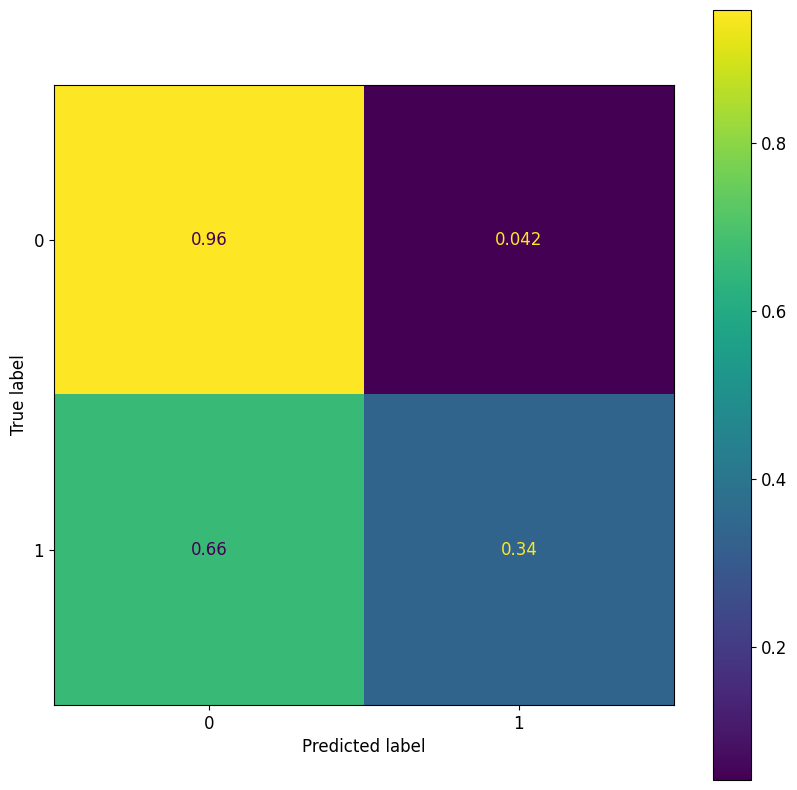

Scoring metric: precision_macro
Best Estimator: DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2}
Best Score: 0.7668776045808517
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7719
           1       0.70      0.33      0.45      2181

    accuracy                           0.82      9900
   macro avg       0.77      0.65      0.67      9900
weighted avg       0.81      0.82      0.80      9900

Monthly value -34673.79746612131 for score precision_macro


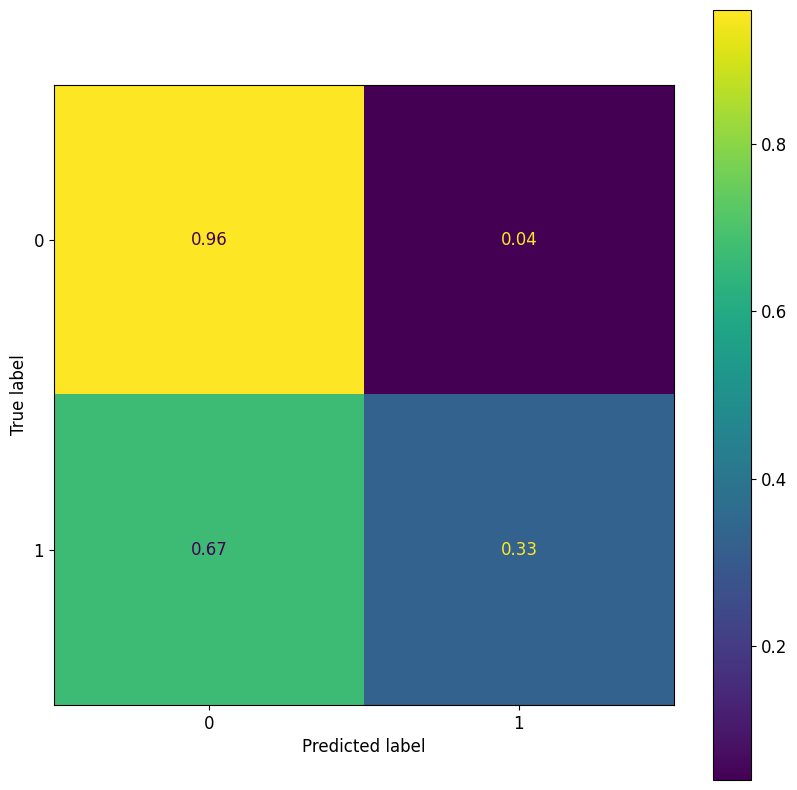

Scoring metric: recall_macro
Best Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, random_state=0)
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5}
Best Score: 0.6955463874926963
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7719
           1       0.49      0.56      0.53      2181

    accuracy                           0.78      9900
   macro avg       0.68      0.70      0.69      9900
weighted avg       0.79      0.78      0.78      9900

Monthly value 9341.632403510295 for score recall_macro


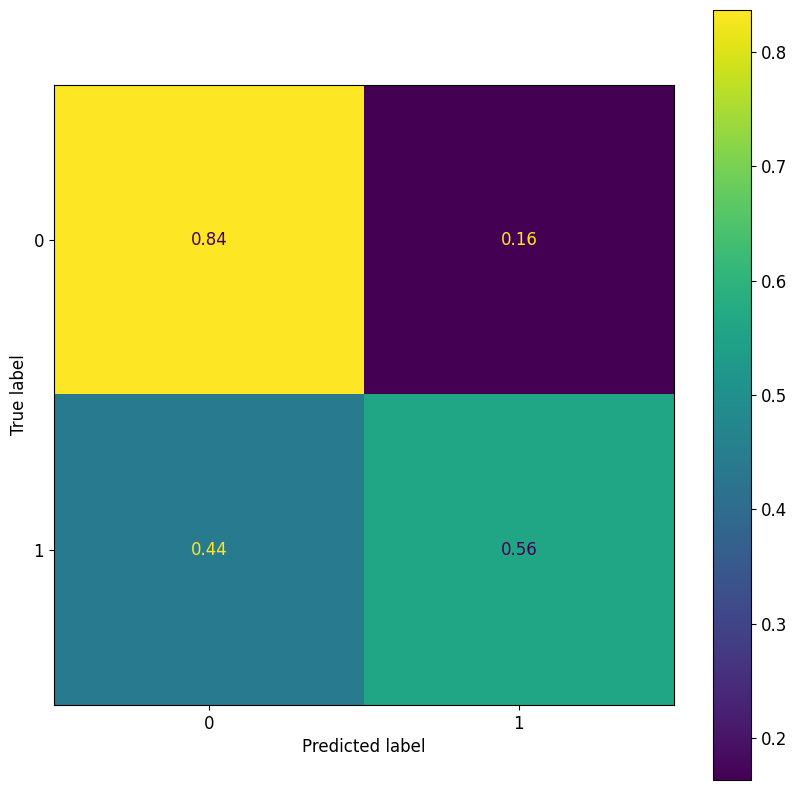

Scoring metric: f1_macro
Best Estimator: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=0)
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 1}
Best Score: 0.6831471530455805
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7719
           1       0.50      0.53      0.51      2181

    accuracy                           0.78      9900
   macro avg       0.68      0.69      0.69      9900
weighted avg       0.78      0.78      0.78      9900

Monthly value 3433.4435848732883 for score f1_macro


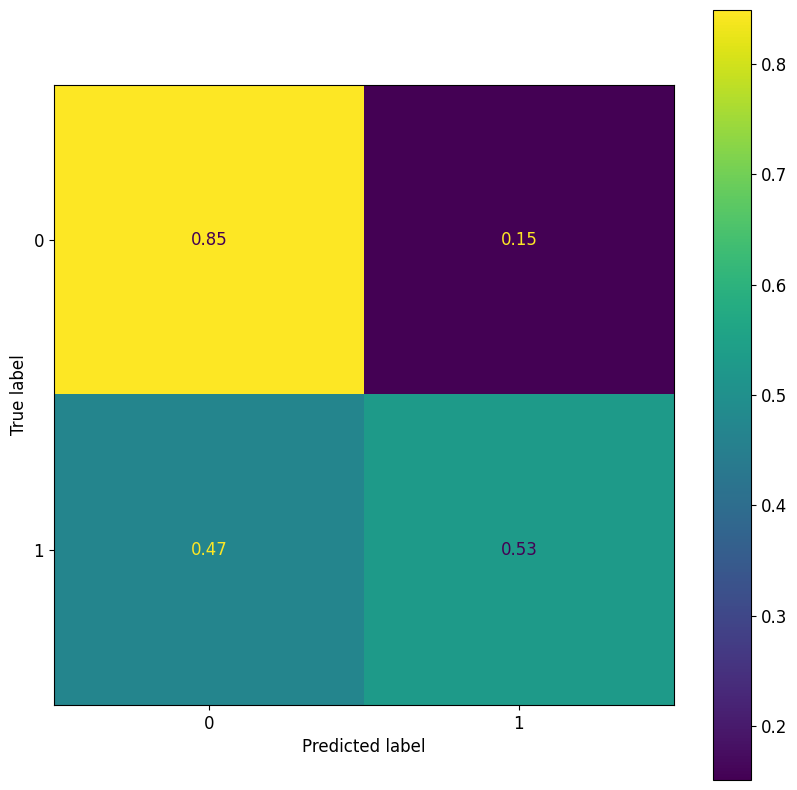

In [16]:
for score in scores:
    print(f"Scoring metric: {score}")
    
    grid_search = GridSearchCV(dtc, param_grid=param, cv=skf, scoring=score, return_train_score=True)
    grid_search.fit(Xtrain, ytrain)
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print("Best Estimator:", best_estimator)
    print("Best Parameters:", best_params)
    print("Best Score:", best_score)
    
    # Predict on the test set
    y_pred = grid_search.predict(Xtest)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(ytest, y_pred))
    
    # Generate confusion matrix
    confusion_mat = confusion_matrix(ytest, y_pred, normalize='true')
       
    # Display the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
    disp.plot()

    # Monthly Value
    monthly_value=np.sum(confusion_mat*cost_matrix)*customer_x_month
    print(f"Monthly value {monthly_value} for score {score}")

    plt.show() 
    